<div style="background-color:rgba(230, 245, 255, 1.0); text-align:center; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(0, 153, 255, 1.0); color: #000000;">

<h1><strong>MIT Quantum Winter School</strong></h1>

<h1><strong>Day 4 - Applications</strong></h1>

<img src="figures/course_logo.png" width="500"/>

</div>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

# Importing standard Qiskit libraries
import qiskit
import qiskit_aer
import pylatexenc
from qiskit import *
from qiskit_aer import *
from qiskit.compiler import transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_vector
from qiskit.quantum_info import Statevector, DensityMatrix, random_statevector
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.circuit.library import GroverOperator, MCMT, ZGate

# QWS helpers
from helpers import convert_to_basis_string, get_all_pauli_strings,interactive_sine_waves, double_slit_experiment

# Bokeh interactive plotting
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Slider, ColumnDataSource, CustomJS, Range1d, Toggle, Button, SetValue
from bokeh.layouts import column, row
from bokeh.io import push_notebook
# Initialize the notebook output
output_notebook()

nshots = 10000

Loading BokehJS ...

# Shor's Algorithm

I implemented Shor's algorithm in Python. If you would like, explore the code or interact with the algorithm by running the function in the cell below.

In [3]:
# Designed by Om Joshi
# Shor's Algorithm Simulator, self-ported to Python from Matlab

import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, gcd, ceil, log2

# https://en.wikipedia.org/wiki/Shor%27s_algorithm
# see above link for explanation of algorithm

def shor_algorithm(plot_qft=False, safety_mode=True):
    print("Shor's Algorithm Simulator, designed by Om Joshi")
    N = int(input("What number do you want to factor? N = ")) # our factorization target
    Q = 2**ceil(log2(N))

    if N > 80 and safety_mode:
        raise ValueError("This will probably break your computer. Please re-run with a smaller value of N or with safety_mode=False")

    # generate the QFT by computing roots of unity (sped up by memoizing)
    qft = np.zeros((Q,Q), dtype='complex')
    root_lookup = {}
    for i in range(Q):
        for j in range(Q):
            if i*j in root_lookup:
                qft[i][j] = root_lookup[i*j]
            else:
                root = np.exp(1j*2*np.pi*i*j/Q)/sqrt(Q)
                root_lookup[i*j] = root
                qft[i][j] = root

    # loop until we find a suitable x value
    while True:
        x = int(input(f"Pick a number x where 1 < x < {N}: x = "))
        if x <= 1 or x >= N:
            continue

        if (g:=gcd(N,x)) != 1:
            print(f"Hooray! gcd({N},{x}) = {g} which is a factor of {N}.")
            break
        
        r_reg = np.zeros((Q), dtype='complex') # input state

        # simulate the partial measurement of the powmod register as `target`
        target = pow(x, int(np.random.choice(range(Q))), N)
        
        # collapse the state to values of r where x^r = target mod N,
        # setting r_reg = 1 to indicate an equal superposition over such r
        for i in range(Q):
            if pow(x,i,N) == target:
                r_reg[i] = 1
        
        r_reg /= np.linalg.norm(r_reg) # normalize the resulting state vector

        k_reg = qft@r_reg # apply the qft -> k domain
        k_abs = np.abs(k_reg*k_reg) # compute the probability vector

        if plot_qft:
            # plot the probability of each value in the k domain
            fig, ax = plt.subplots()
            ax.plot(range(Q),k_abs,'o')
            ax.set_title(f"QFT for N={N} Q={Q} x={x}");
            ax.set_xlim(-Q/10, Q+Q/10)
            ax.set_xlabel("k");
            ax.set_ylabel("P(k)")
        
        # simulate measurement of the top few k values
        # using |k_reg| as measurement probability
        top = 20
        k_top = np.random.choice(range(Q), top, p=k_abs)/Q
        print(f"These are the approximate values of c/s after {top} measurements:")
        print(k_top)
        print("Each value is very close to a fraction with a small denominator s_i.")
        # prompt for user input to determine the period s based on measured values
        s = int(input("What do you think s = lcm(s_i) is? s = "))
        if s % 2 == 0 and (root:=pow(x,s//2,N)) != N-1: # nontrivial square root
            print(f"If everything went right, {N} = {gcd(N,root+1)} * {gcd(N,root-1)}.")
            break
        print("You were unlucky! Try again with a different x value!")

Shor's Algorithm Simulator, designed by Om Joshi


What number do you want to factor? N =  15
Pick a number x where 1 < x < 15: x =  4


These are the approximate values of c/s after 20 measurements:
[0.5 0.5 0.  0.5 0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0.5 0.  0.5
 0.5 0. ]
Each value is very close to a fraction with a small denominator s_i.


What do you think s = lcm(s_i) is? s =  2


If everything went right, 15 = 5 * 3.


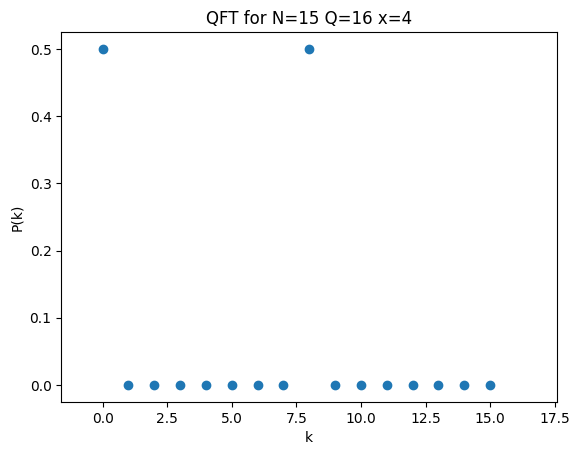

In [4]:
shor_algorithm(plot_qft=True)